<center>Заметка 6.а Поиск по образцу</center>
<center>курса <q>Введение в цифровую обработку изображений</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.09</center>

<center>Аннотация</center>
<p>
...
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

/opt/conda/envs/myTF/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h2>Бинарные изображения</h2>

Для начала напомню что есть бинарное изображение.

In [2]:
img = np.zeros((100, 300), "uint8")

In [3]:
font                   = cv.FONT_HERSHEY_SIMPLEX
fontScale              = 1
lineType               = cv.LINE_4

In [4]:
cv.putText(img,'Hello World!', 
    (30, 30), 
    font, 
    fontScale,
    200,
    lineType);

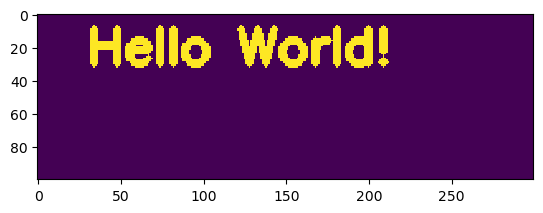

In [5]:
plt.imshow( img, interpolation = 'none' );

В качестве примера будем рассматривать бинарное изображение с текстом (можно рассматривать любой другой объект, выделенный с помощью пороговой функции). Как и в предыдущих лекциях, мы сперва рассмотрим синтезированные данные, а потом перейдём к более реалистичным примерам. Идея состоит в следующем: возьмём некий образец, который есть на изображении (например, букву) и будем его везде на картинке прикладывать. Сформируем и бинарный шаблон, который будем искать в изображении (в данном случае, букву "о").

In [6]:
tmpl = np.zeros((21, 20), "uint8");

In [7]:
cv.putText(tmpl,'o', 
    (0,17), 
    font, 
    fontScale,
    200,
    lineType);

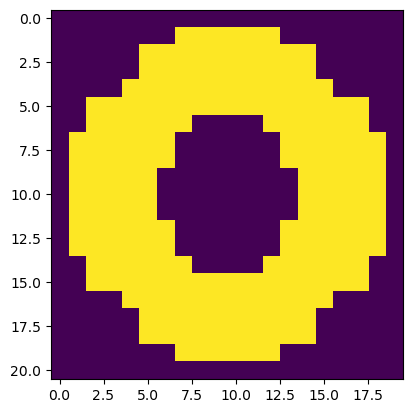

In [8]:
plt.imshow( tmpl );

Выполним поиск шаблона в изображении используя метод поиска по образцу. (функция matchTemplate. Данная функция в качестве параметров принимает изображение, на котором выполняется поиск (img), образец (tmpl), третий параметр задаёт способ поиска. Для более детального ознакомления см. документацию. Функция возвращает новое изображение, значением которого является корреляция)

In [9]:
print( 'Исходное изображение: ', img.shape, img.dtype )
cc = cv.matchTemplate(img, tmpl, cv.TM_CCORR_NORMED)
print( 'Корреляционное: ', cc.shape, cc.dtype)
cc

Исходное изображение:  (100, 300) uint8
Корреляционное:  (80, 281) float32


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Видим, что размер выходного изображения уменьшился на размер шаблона (-1).

Отсортируем значения в корреляционом изображении.

In [10]:
# Для начала выпрямим изображение в один вектор.
dd = cc.flatten() # Преврашаем изображение в вектор.
dd.shape, dd.dtype

((22480,), dtype('float32'))

In [11]:
# теперь отсортируем по возрастанию
dd.sort()

In [12]:
# Выведем 5 самых больших значений.
dd[-5:]

array([0.8761905, 0.8761905, 0.919692 , 1.       , 1.       ],
      dtype=float32)

Видно, что как раз две 1, т.е. точное совпадение с шаблоном на двух участках изображения.

In [13]:
# Надем, где эти единицы в корреляционном изображении. Создаём массив из истины и лжи, где истина в тех местах, 
# где корреляция равна 1
qq = cc == 1

In [14]:
pp = np.where(qq)
pp

(array([13, 13]), array([ 86, 145]))

Точки заданы как обычно индексы.
Так сначала строка, а потом столбец.

Координаты в обычном понимании достигаются путем перестановки.

In [15]:
print( 'xы: ', pp[1], '; yи: ', pp[0] )

xы:  [ 86 145] ; yи:  [13 13]


Проверим, что в этих точка действительно истинна.

In [16]:
qq[13,86], qq[13,145]

(True, True)

In [17]:
# Всего ненулевых.
np.count_nonzero( qq )

2

Отрисуем точки, в которых корреляция равна 1, на корреляционном изображении. Убедимся, что поиск по шаблону выполнен успешно

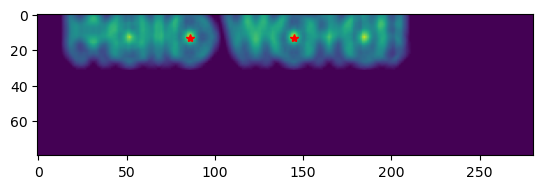

In [18]:
plt.imshow( cc )
plt.plot( pp[1], pp[0], "r*");

Нам бы хотелось поставить точки и на исходном изображении

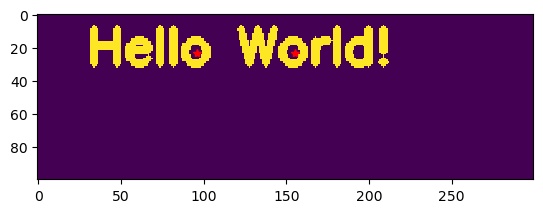

In [19]:
plt.imshow( img, interpolation = 'none' )
plt.plot( pp[1]+10, pp[0]+10, "r*");

Как мы видим произошло смещение. Это происходит из-за того, что при прогонке шаблона находится координата верхнего левого угла. Нужно учесть размер шаблона.
Если хотим поставить в центре буквы о, то нужно брать центр шаблона. (наш шаблон имеет размер 21х21)

Т.о. мы рассмотрели случай, когда у нас идеальное совпадение шаблона на  изображении.

<b>Маска, регион интереса</b>

Покажем важность маски при поиске по образцу

In [20]:
imgn = img.copy()

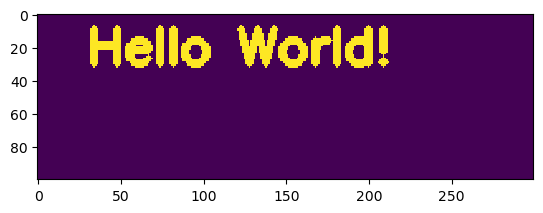

In [21]:
plt.imshow( imgn, interpolation = 'none' );

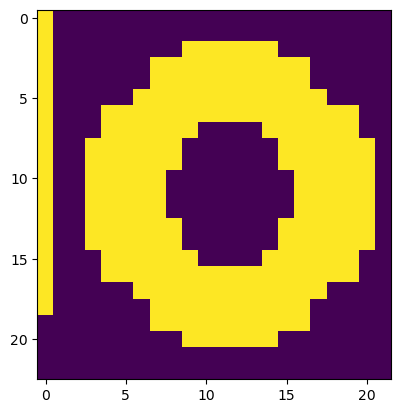

In [22]:
plt.imshow( imgn[12:35,84:106] );

Перейдём к неидеальному случаю. Для этого испортим окрестность у буквы о, добавив лишние точки (шум).

In [23]:
imgn[14:17,87] = 200
imgn[14,89] = 200
imgn[14,102] = 200
imgn[14:16,104] = 200
imgn[30:33,87] = 200
imgn[31,87:90] = 200
imgn[30,103:105] = 200
imgn[31,103] = 200
imgn[32,102:105] = 200

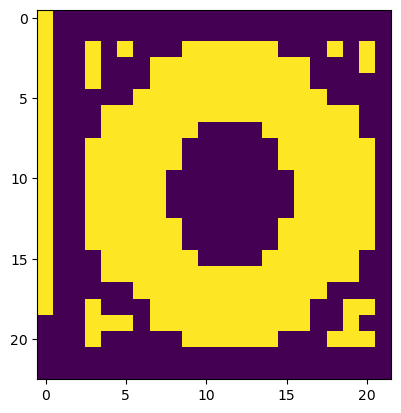

In [24]:
plt.imshow( imgn[12:35,84:106], interpolation = 'none' );

Теперь отчетливо видно, что окрестность буквы о испорчена.

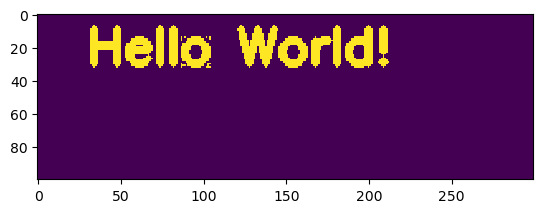

In [25]:
plt.imshow( imgn, interpolation = 'none' );

Далее все по аналогии...

In [26]:
cc = cv.matchTemplate(imgn, tmpl, cv.TM_CCORR_NORMED)

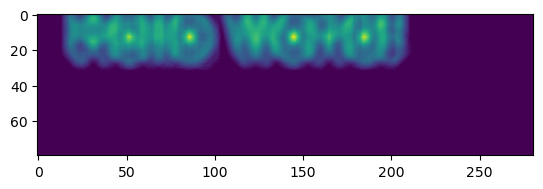

In [27]:
plt.imshow( cc ); # посмотрим на корреляционное изображение

In [28]:
dd = cc.flatten()
dd.sort()

In [29]:
dd[-5:]

array([0.87619036, 0.8761904 , 0.919692  , 0.95971495, 1.        ],
      dtype=float32)

Как видем один из максимум существено потускнел. Теперь корреляция равна 1 только в одной точке. Это можно учесть либо понизив порог корреляции (например, сказать, что если корреляция >= 0.95, то имеет место совпадение шаблона), либо изменив алгоритм.
Т.е. необходимо использовать маску, которая скажет, где существенные части объекта. (ищем букву "о", а то, что вне данной буквы, нас не интересует)

In [30]:
tmpl_msk = tmpl.copy()
mask = np.zeros((tmpl_msk.shape[0]+2, tmpl_msk.shape[1]+2), np.uint8)
np.unique( tmpl_msk)

array([  0, 200], dtype=uint8)

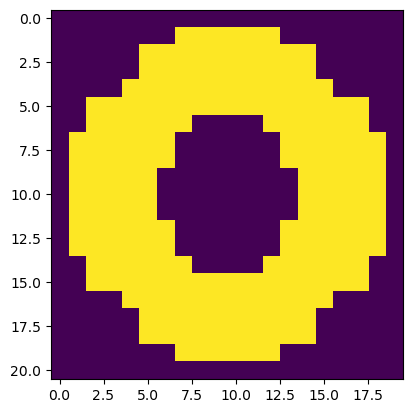

In [31]:
plt.imshow( tmpl_msk );

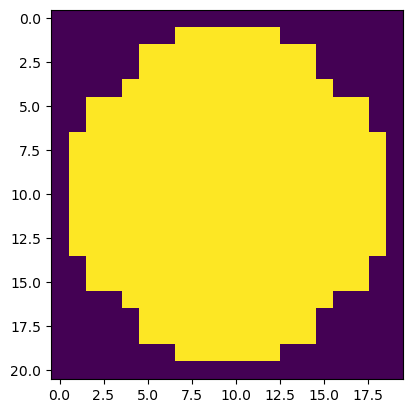

In [32]:
cv.floodFill( tmpl_msk, mask, (10,10), 200 )
plt.imshow( tmpl_msk );

Маской будет буква с заполненной внутренностью. (т.к. важно всё, что внутри буквы, а всё, что снаружи, неважно)

In [33]:
tmpl_msk.shape, tmpl_msk.dtype

((21, 20), dtype('uint8'))

In [34]:
tmpl.shape, tmpl.dtype

((21, 20), dtype('uint8'))

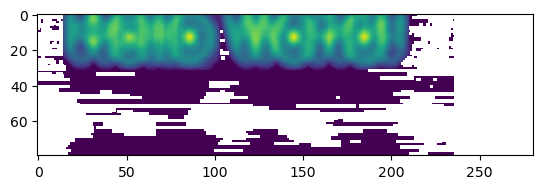

In [35]:
cc = cv.matchTemplate(imgn, tmpl, cv.TM_CCORR_NORMED, None, mask = tmpl_msk)
plt.imshow( cc );

Действуя по аналогии видим, что появилось много не чисел (inf и nan). Nan возникает при делении на ноль, это возможно в случае, если ни один пиксель не попадает в маску, и при вычислении корреляции происходит деление на ноль

In [36]:
dd = cc.flatten()
dd.sort()
dd

array([-inf, -inf, -inf, ...,  nan,  nan,  nan], dtype=float32)

Убираем такие числа путем отбора "конечных" чисел.

In [37]:
dd = dd[ np.isfinite(dd) ]
dd

array([-7.610750e-08, -5.553378e-08, -3.791591e-08, ...,  9.760066e-01,
        1.000000e+00,  1.000000e+00], dtype=float32)

In [38]:
dd[-5:]

array([0.91634196, 0.91656065, 0.9760066 , 1.        , 1.        ],
      dtype=float32)

Как видим опять два положения буквы найдены. Т.е. не смотря на шум имеем полное совпадение.

In [39]:
qq = cc == 1

In [40]:
pp = np.where( qq )
pp

(array([13, 13]), array([ 86, 145]))

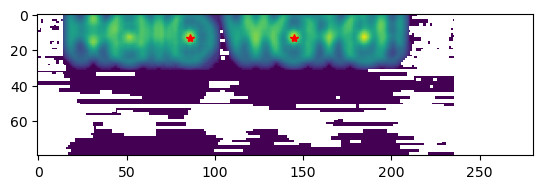

In [41]:
plt.imshow( cc )
plt.plot( pp[1], pp[0], "r*");

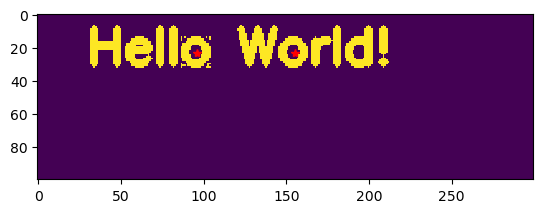

In [42]:
plt.imshow( imgn, interpolation = 'none' )
plt.plot( pp[1]+10, pp[0] + 10, "r*");

Нашли букву несмотря на шум. Приэтом, с высокой корелляцией (а точнее равной 1).

<h2>Градиентные изображения</h2>

Рассмотренный ранее метод применим не только к бинарным изображениям.

При использовании метода поиска по шаблону совсем необязательно исползовать изображения,
можно и их градиенты. Фактически тем самым мы заставляем метод обращать внимание на границы в исходном изображении.

Загружаем само изображение.

In [43]:
med = cv.imread( './data/med/test1_zps5c837397.png' )
med.shape

(480, 640, 3)

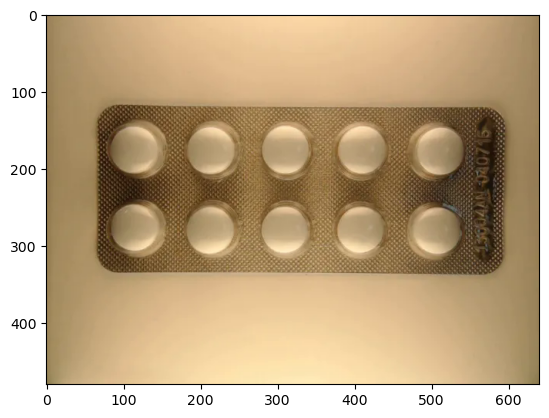

In [44]:
plt.imshow( med );

и отдельно загружаем шаблон.

In [45]:
med0 = cv.imread( './data/med/test1-1_zps89eaefa0.png' )
med0.shape

(71, 69, 3)

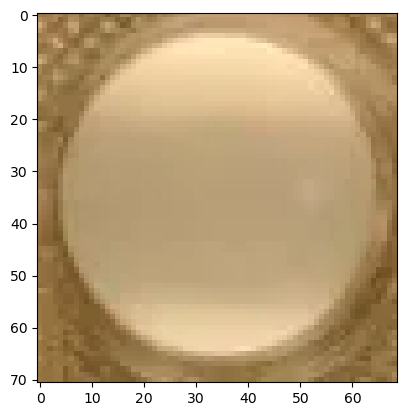

In [46]:
plt.imshow( med0 );

Выполним поиск по образцу.

In [47]:
cc = cv.matchTemplate( med, med0, cv.TM_CCOEFF_NORMED) # TM_CCORR_NORMED
cc.shape

(410, 572)

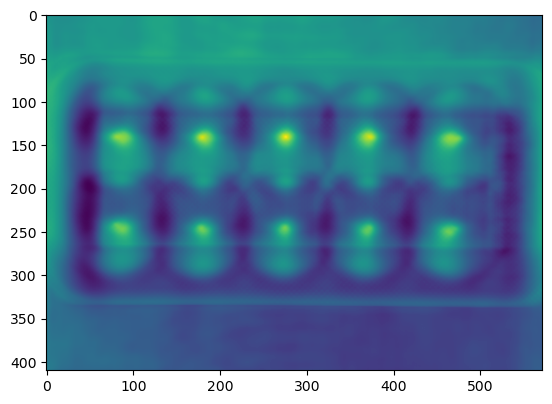

In [48]:
plt.imshow( cc );

In [49]:
dd = cc.flatten()
dd.sort()
dd.dtype

dtype('float32')

In [50]:
np.min( dd ), np.max( dd ) # заметим, что даже максимальная корреляция не равна 1

(-0.5495351, 0.9924527)

In [51]:
# Избавляемся от отрицательных чисел.
cc = np.clip( cc, 0, 1) # это необходимо для того, чтобы далее превратить изображение в 8-битное беззнаковое число

In [52]:
np.min( cc ), np.max( cc )

(0.0, 0.9924527)

In [53]:
cc = np.uint8(cc*255) # это делается в том числе для того, чтобы корректно отобразить изображение
cc.dtype

dtype('uint8')

In [54]:
np.min( cc ), np.max( cc )

(0, 253)

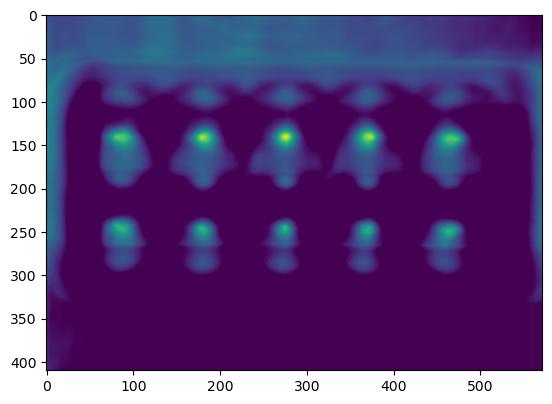

In [55]:
plt.imshow( cc );

Корректный поиск центра шаблона.

In [56]:
size = int(((med0.shape[0]+med0.shape[1]) / 4) * 2 + 1)
size

71

Используем адаптивный пороговый фильтр для учета неравномерное освещение в картинке. (ищется среденее значение и, если текущее значение выше среднего, пороговая функция срабатывает)

In [57]:
res = cv.adaptiveThreshold(cc, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, size, -128)

In [58]:
np.min( res ), np.max( res )

(0, 255)

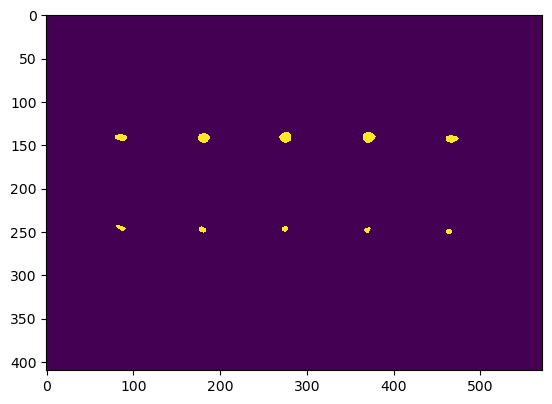

In [59]:
plt.imshow( res, interpolation = 'none' );

Избыточная проверка на всякий случай.

In [60]:
res = res > 0.99*255

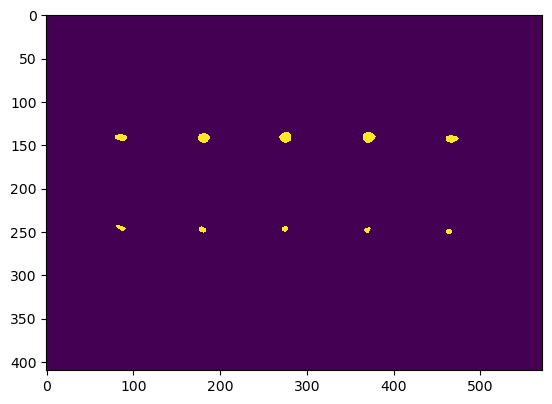

In [61]:
plt.imshow( res, interpolation = 'none' );

Нашли, но они какие-то все разные.
Найдены с разной чувствительностью.
Это не всегда хорошо.

упр. найти количество таблеток

<b>Градиенты</b>

In [62]:
medg = cv.cvtColor( med, cv.COLOR_RGB2GRAY ) #преобразуем изображение и шаблон в серый цвет
med0g = cv.cvtColor( med0, cv.COLOR_RGB2GRAY )

In [63]:
low_canny = 110

In [64]:
medgf = cv.Canny( medg, low_canny, low_canny*3)
med0gf = cv.Canny( med0g, low_canny, low_canny*3)

Искать градиент шаблона мы конечно будем не на исходном изображении, а на его градиенте. (т.е на изображении с выделенными границами)

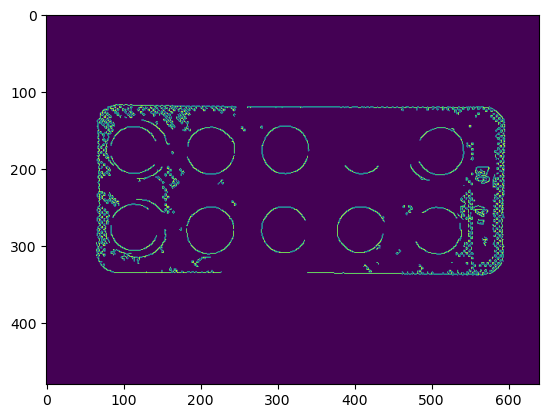

In [65]:
plt.imshow( medgf );

Вот так выглядит градиент шаблона. Такое изображение и будет использоваться в качестве шаблона теперь.

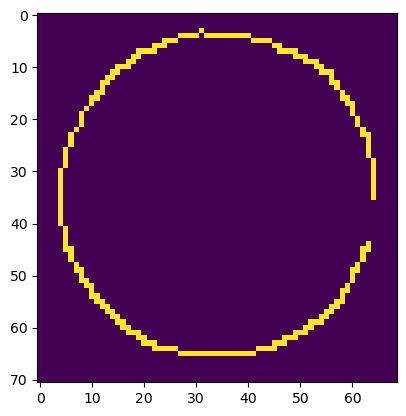

In [66]:
plt.imshow( med0gf, interpolation = 'none' );

Применим метод поиска по образцу, но градиент шаблона к градинтному изображению. (фактически мы перешли к бинарным изображениям)

In [67]:
cc = cv.matchTemplate( medgf, med0gf, cv.TM_CCOEFF_NORMED) # TM_CCORR_NORMED
cc.shape

(410, 572)

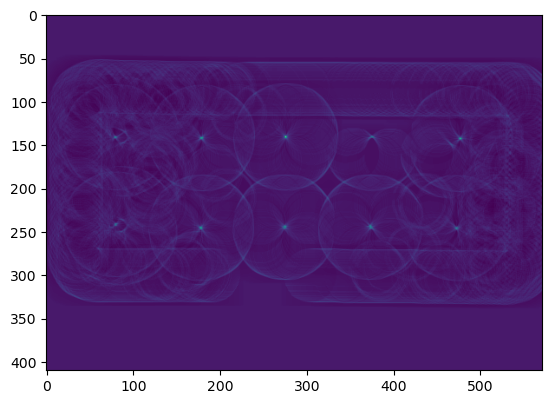

In [68]:
plt.imshow( cc );

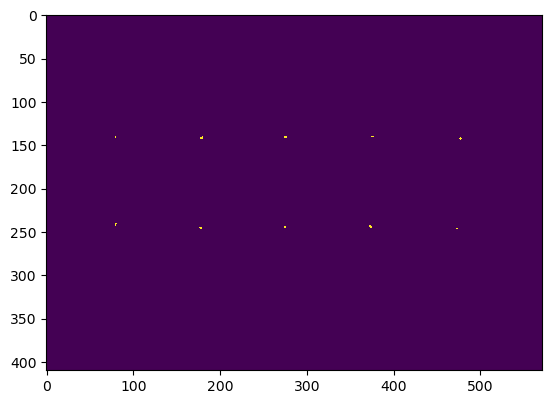

In [69]:
plt.imshow( cc > 0.23, interpolation='none' );

Видим, что в сравнеии с обычным методом поиска по шаблону, выделеные области более точечные и схожего размера.

<h2>Примеры</h2>

Приведем пример использования метода поиска по образцу
на изображения с круглыми метками

In [70]:
f_seg = './data/дырки_метки/'

In [71]:
im1 = cv.imread( f_seg + 'DSC_0825.JPG' )[:,:,::-1]
im1.shape

(3264, 4928, 3)

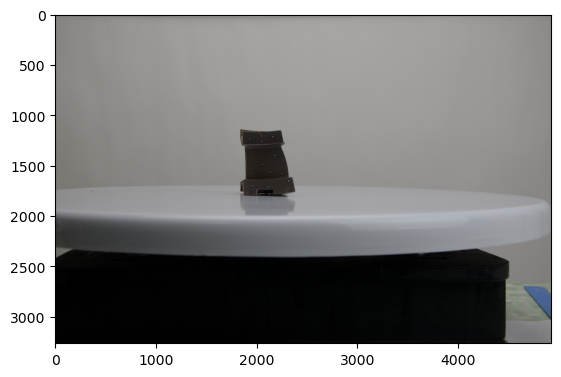

In [72]:
plt.imshow( im1 );

Откадрируем интересующий нас объект. Такие метки часто используют для того, чтобы выполнить трёхмерную реконструкцию. Хотим найти эти колибровочные точки на изображении.

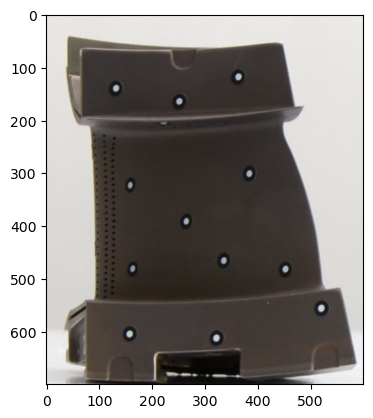

In [73]:
obj1 = im1[1100:1800,1800:2400] # вырезаем интересующую нас часть изображения
plt.imshow( np.uint8(obj1*1.5) );

Откадрируем и непосредственно саму метку, которую будем искать.

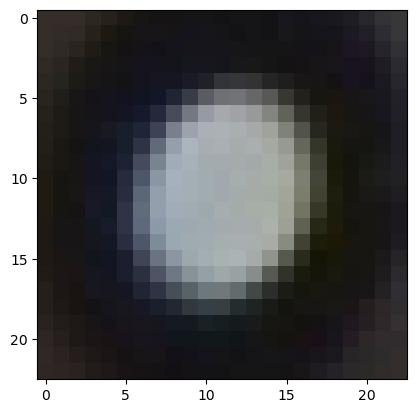

In [74]:
met1 = obj1[ 455:478, 325:348 ]
plt.imshow( np.uint8(met1*1.5) );

In [75]:
met1.shape

(23, 23, 3)

Откадрируем ещё одну метку.

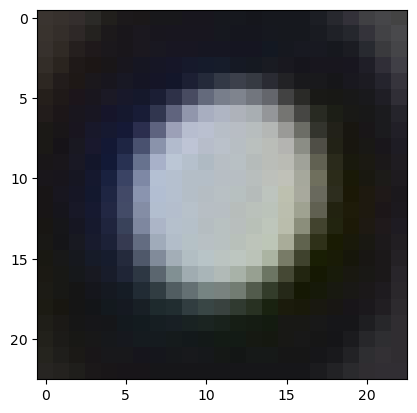

In [76]:
met2 = obj1[ 129:152, 121:144 ]
plt.imshow( np.uint8(met2*1.5) );

Видно, что они очень похожи. Даже размером совпадают.

In [77]:
met2.shape

(23, 23, 3)

Найдем метки на изображении используя этот шаблон.

In [78]:
im1gr = cv.cvtColor( obj1, cv.COLOR_RGB2GRAY )
im1gr.shape

(700, 600)

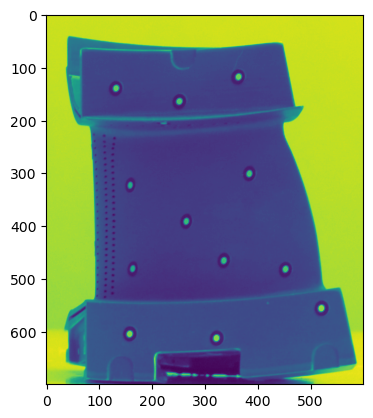

In [79]:
plt.imshow( im1gr );

In [80]:
met1gr = im1gr[ 455:478, 325:348 ]
met1gr.shape

(23, 23)

In [81]:
cc = cv.matchTemplate(im1gr, met1gr, cv.TM_CCORR_NORMED) # корреляционное изображение
cc.shape

(678, 578)

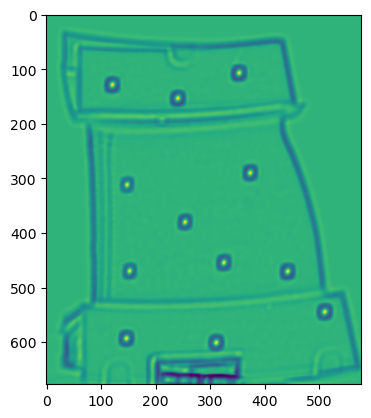

In [82]:
plt.imshow( cc );

In [83]:
import scipy.stats as stats

In [84]:
np.min( cc ), np.max( cc )

(0.21993089, 0.9999998)

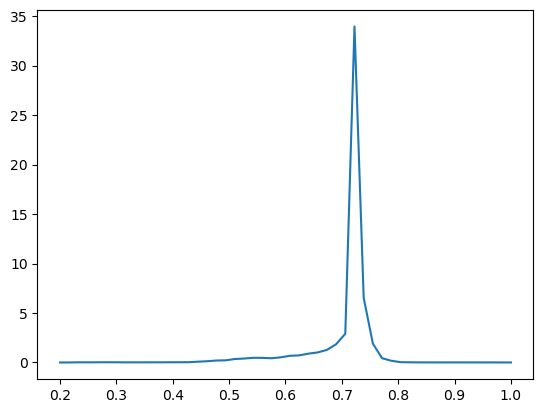

In [85]:
sm = stats.gaussian_kde( cc.flatten() )
val = np.linspace(0.2, 1, 50)
plt.plot( val, sm( val ) ); # аппроксимируем плотность распределения на корреляционном изображении

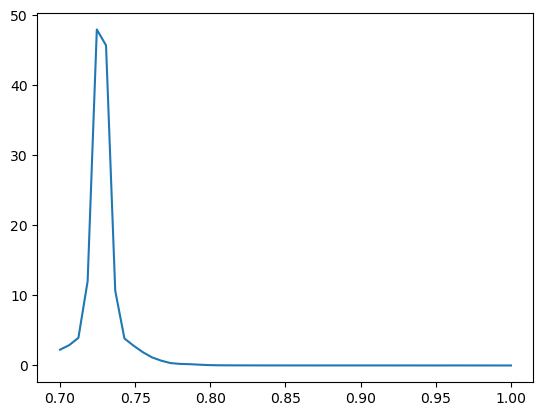

In [86]:
sm = stats.gaussian_kde( cc.flatten() )
val = np.linspace(0.7, 1, 50)
plt.plot( val, sm( val ) );

В итоге, нас интересует эта часть графика.

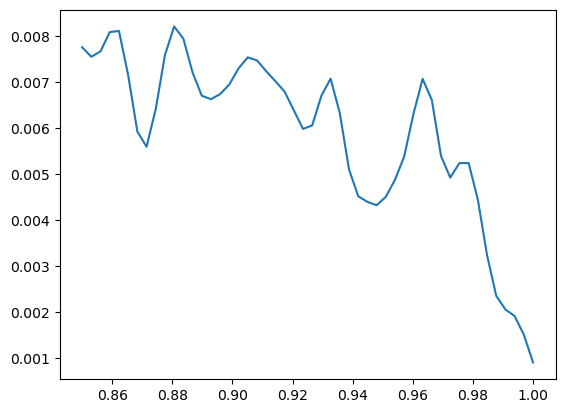

In [87]:
sm = stats.gaussian_kde( cc.flatten() )
val = np.linspace(0.85, 1, 50)
plt.plot( val, sm( val ) );

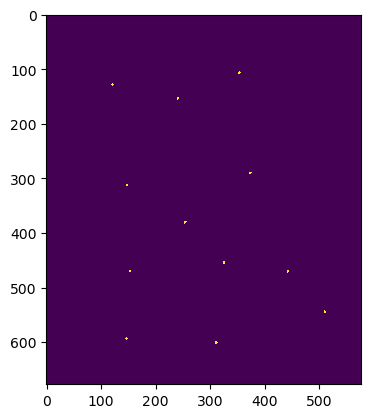

In [88]:
mrkrs1 = (cc>0.9).astype("uint8") # отобразим точки, в которых корреляция выше, чем 0.9
plt.imshow( mrkrs1, interpolation = 'none' );

In [89]:
np.unique( mrkrs1 )

array([0, 1], dtype=uint8)

In [90]:
retv, lab, pla, cent = cv.connectedComponentsWithStats( mrkrs1 )
cent = cent[1:] # Убираем центр фона.
cent.shape

(12, 2)

In [91]:
met1gr.shape

(23, 23)

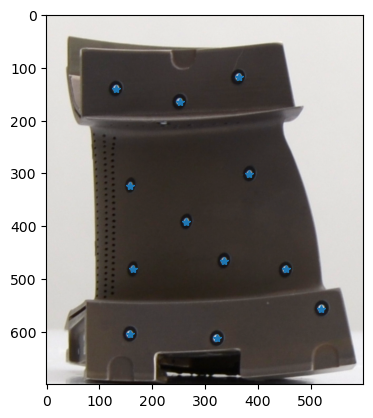

In [92]:
obj1 = im1[1100:1800,1800:2400]
plt.imshow( np.uint8(obj1*1.5) )
plt.plot( cent[:,0]+23//2, cent[:,1]+23//2, "*" );

Все отметки нашли.